# Comparing local and distributed batch training

Using this notebook to compare two training configurations with same global batch size:
- all on one device
- distributed across devices with DDP and gradient reductions

The potential issue here is that the gradient averaging can be biased in the distributed case when samples are different sizes.

In [27]:
%pwd

'/global/u2/s/sfarrell/WorkAreas/trackml/heptrkx-gnn-tracking/notebooks'

In [28]:
# System imports
import os
import sys
import pprint

# External imports
import matplotlib.pyplot as plt
import numpy as np

# Limit CPU usage on Jupyter
os.environ['OMP_NUM_THREADS'] = '4'

# Pick up local packages
sys.path.append('..')

# Local imports
from trainers import get_trainer
from nb_utils import (load_config_file, load_config_dir, load_summaries,
                      plot_train_history, get_test_data_loader,
                      compute_metrics, plot_metrics, draw_sample_xy)

In [29]:
%matplotlib inline

In [30]:
plt.rcParams['font.size'] = '14'

## Load training results

Specify which results to load either by config file or training output directory.

In [31]:
# Load by directory (preferred)
result_base = os.path.expandvars('$SCRATCH/heptrkx/results')

In [32]:
ls $result_base

RNNFilter_20180207_1121/  gnnsegclf_big_002/    mpnn_002/      resepnn_big_001/
agnn_000/                 gnnsegclf_big_003/    mpnn_batch/    resepnn_big_003/
agnn_001/                 gnnsegclf_med_000/    mpnn_big_000/  resmpnn_001/
agnn_002/                 gnnsegclf_med_009/    mpnn_big_001/  resmpnn_002/
agnn_002_8gpu/            gnnsegclf_med_010/    mpnn_big_002/  resmpnn_002a/
agnn_big_000/             gnnsegclf_med_011/    mpnn_big_003/  resmpnn_002b/
agnn_big_001/             gnnsegclf_small_000/  mpnn_big_004/  resmpnn_big_000/
agnn_big_002/             gnnsegclf_small_001/  mpnn_big_005/  resmpnn_big_001/
agnn_scaling/             gnnsegclf_small_002/  mpnn_big_006/  resmpnn_big_002/
gnnsegclf_000/            gnnsparse_big_001/    mpnn_big_007/  resmpnn_big_003/
gnnsegclf_001/            gnnsparse_med_001/    mpnn_big_008/  stable_big_001/
gnnsegclf_004/            hello/                mpnn_med_000/  temp/
gnnsegclf_big_000/        mpnn_001/             mpnn_med_001/  tes

In [33]:
# Non-distributed, baseline results
result_name = 'resmpnn_002'
result_dir = os.path.join(result_base, result_name)
config = load_config_dir(result_dir)
summaries = load_summaries(config)

In [34]:
# Distributed results
result_name = 'resmpnn_002a'
result_dir = os.path.join(result_base, result_name)
dist_config = load_config_dir(result_dir)
dist_summaries = load_summaries(dist_config)

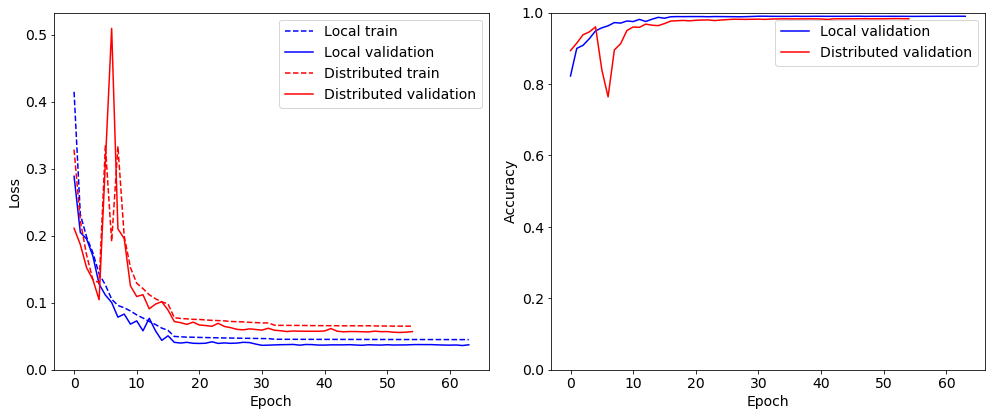

In [35]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(14, 6))

# Plot losses
ax0.plot(summaries.epoch, summaries.train_loss, 'b--', label='Local train')
ax0.plot(summaries.epoch, summaries.valid_loss, 'b-', label='Local validation')
ax0.plot(dist_summaries.epoch, dist_summaries.train_loss, 'r--', label='Distributed train')
ax0.plot(dist_summaries.epoch, dist_summaries.valid_loss, 'r-', label='Distributed validation')
ax0.set_xlabel('Epoch')
ax0.set_ylabel('Loss')
ax0.set_ylim(bottom=0)
#ax0.set_yscale('log')
ax0.legend(loc=0)

# Plot accuracies
ax1.plot(summaries.epoch, summaries.valid_acc, 'b-', label='Local validation')
ax1.plot(dist_summaries.epoch, dist_summaries.valid_acc, 'r-', label='Distributed validation')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_ylim(bottom=0, top=1)
ax1.legend(loc=0)

plt.tight_layout()

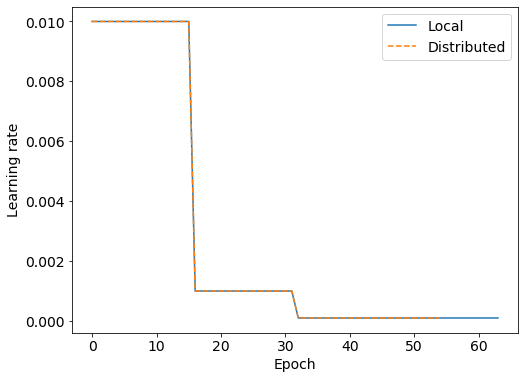

In [36]:
# Confirm that the same learning rates were used
plt.figure(figsize=(8,6))
plt.plot(summaries.lr, label='Local')
plt.plot(dist_summaries.lr, '--', label='Distributed')
plt.xlabel('Epoch')
plt.ylabel('Learning rate')
plt.legend(loc=0);

## Discussion

Here we used our most powerful model (resmpnn) with batch size 4 and compared single-gpu training with 4-gpu training.

The distributed training in this case is shown to be less stable and struggles to converge compared to the single node training.